Predictive Statistics
=====================
This notebook uses the `sklearn` library to run some machine learning
predictions using regression analysis. It has examples of both
Ordinary Least Square and Partial Least Square Regression.

We look at school demographics to see how well we can use those factors
to predict mean_scale_score. We look at the grades 3-8 NYS math exams
for the most recent academic year in our data set.



In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import chi2

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display import Markdown as md

from nycschools import schools, ui, exams


In [2]:
# load the demographic data and merge it with the math data
df = schools.load_school_demographics()

math_df = exams.load_math()

math_df = df.merge(math_df, how="inner", on=["dbn", "ay"])
math_df = math_df[math_df["mean_scale_score"].notnull()]
math_df.head()

,dbn,beds,district,geo_district,boro,school_name_x,short_name,ay,year,total_enrollment,...,level_2_pct,level_3_n,level_3_pct,level_4_n,level_4_pct,level_3_4_n,level_3_4_pct,test_year,charter,school_name_y
0,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,178,...,0.310345,7.0,0.241379,5.0,0.172414,12.0,0.413793,2017,0,NaN
1,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,178,...,0.347826,8.0,0.347826,1.0,0.043478,9.0,0.391304,2017,0,NaN
2,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,178,...,0.294118,8.0,0.470588,2.0,0.117647,10.0,0.588235,2017,0,NaN
3,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,178,...,0.318841,23.0,0.333333,8.0,0.115942,31.0,0.449275,2017,0,NaN
4,01M015,310100010015,1,1,Manhattan,P.S. 015 Roberto Clemente,PS 15,2016,2016-17,178,...,0.391304,6.0,0.260870,4.0,0.173913,10.0,0.434783,2017,0,NaN


Predicting test scores
-------------------------------
Using OLS regression we will see how well we can predict mean_scale_score for the
"All Students" category. We will run this with several variations of factors
to see which factors have the strongest prediction.

The basic ideas of a predictive model is that we will use some of our data to
"train" the model and use the other portion to "test" the model. Once we
calculate a coeefficient for each factor, we can use those values to
adjust the data sets mean score for a particular case.

These examples will use two statistical measures to compare our models:

- r-squared is a number between 0 and 1 that will tell us how closely our predictions
  match the actual recorded score (1 is perfect, 0 is no matches)
- mean squared error (`rmse`) tells us the mean distance between predictions and recorded scores
  in the same scale as our exam; so an rmse of 10 means that, on average, our predictions were
  10 points away from the actual score


### Correlation table
First, let's see how the factors correlate with each other, and with our
dependent variable. This table uses a "coolwarm" color map. Darker red
indicates a strong positive correlation and darker blue a strong negative correlation.


In [3]:
# get just the 2019 test results for All Students
# this will be the dependent variable in our regression
data = math_df.query(f"ay == {math_df.ay.max()} and category == 'All Students'")
# calculate coefficients for these factors
factors = ['total_enrollment', 'asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  
       'poverty_pct', 'charter', "eni", "geo_district"]


dv_stats = data.mean_scale_score.describe()
display(md("**Descriptive statistics for mean scale score**"))

display(pd.DataFrame(dv_stats))

**Descriptive statistics for mean scale score**

,mean_scale_score
count,6194.000000
mean,600.830675
std,11.344600
min,565.111084
25%,592.223618
50%,599.833649
75%,608.619659
max,639.000000


**Correlation table between factors and mean scale score**

,mean_scale_score,total_enrollment,asian_pct,black_pct,hispanic_pct,white_pct,swd_pct,ell_pct,poverty_pct,charter,eni_pct,geo_district
eni_pct,-0.587185,-0.169468,-0.263891,0.266915,0.532394,-0.797134,0.380535,0.420963,0.954089,0.048291,1.000000,-0.129043
poverty_pct,-0.553455,-0.143252,-0.239338,0.311367,0.481236,-0.814254,0.317994,0.398657,1.000000,0.092909,0.954089,-0.014550
swd_pct,-0.536632,-0.351879,-0.353346,0.136179,0.249781,-0.188203,1.000000,-0.023496,0.317994,-0.236692,0.380535,-0.165597
hispanic_pct,-0.346844,-0.060650,-0.329082,-0.419924,1.000000,-0.372532,0.249781,0.491201,0.481236,-0.043585,0.532394,-0.258318
ell_pct,-0.258410,0.078280,0.224635,-0.423411,0.491201,-0.199569,-0.023496,1.000000,0.398657,-0.231778,0.420963,0.049425
black_pct,-0.235805,-0.281028,-0.459831,1.000000,-0.419924,-0.476618,0.136179,-0.423411,0.311367,0.324027,0.266915,-0.001906
geo_district,0.011835,0.207157,0.274706,-0.001906,-0.258318,0.099406,-0.165597,0.049425,-0.014550,-0.124843,-0.129043,1.000000
total_enrollment,0.288875,1.000000,0.354664,-0.281028,-0.060650,0.169663,-0.351879,0.078280,-0.143252,0.018803,-0.169468,0.207157
charter,0.298770,0.018803,-0.226191,0.324027,-0.043585,-0.201707,-0.236692,-0.231778,0.092909,1.000000,0.048291,-0.124843
asian_pct,0.382410,0.354664,1.000000,-0.459831,-0.329082,0.177453,-0.353346,0.224635,-0.239338,-0.226191,-0.263891,0.274706


**Scatter plots of correlations showing covariance of factors**

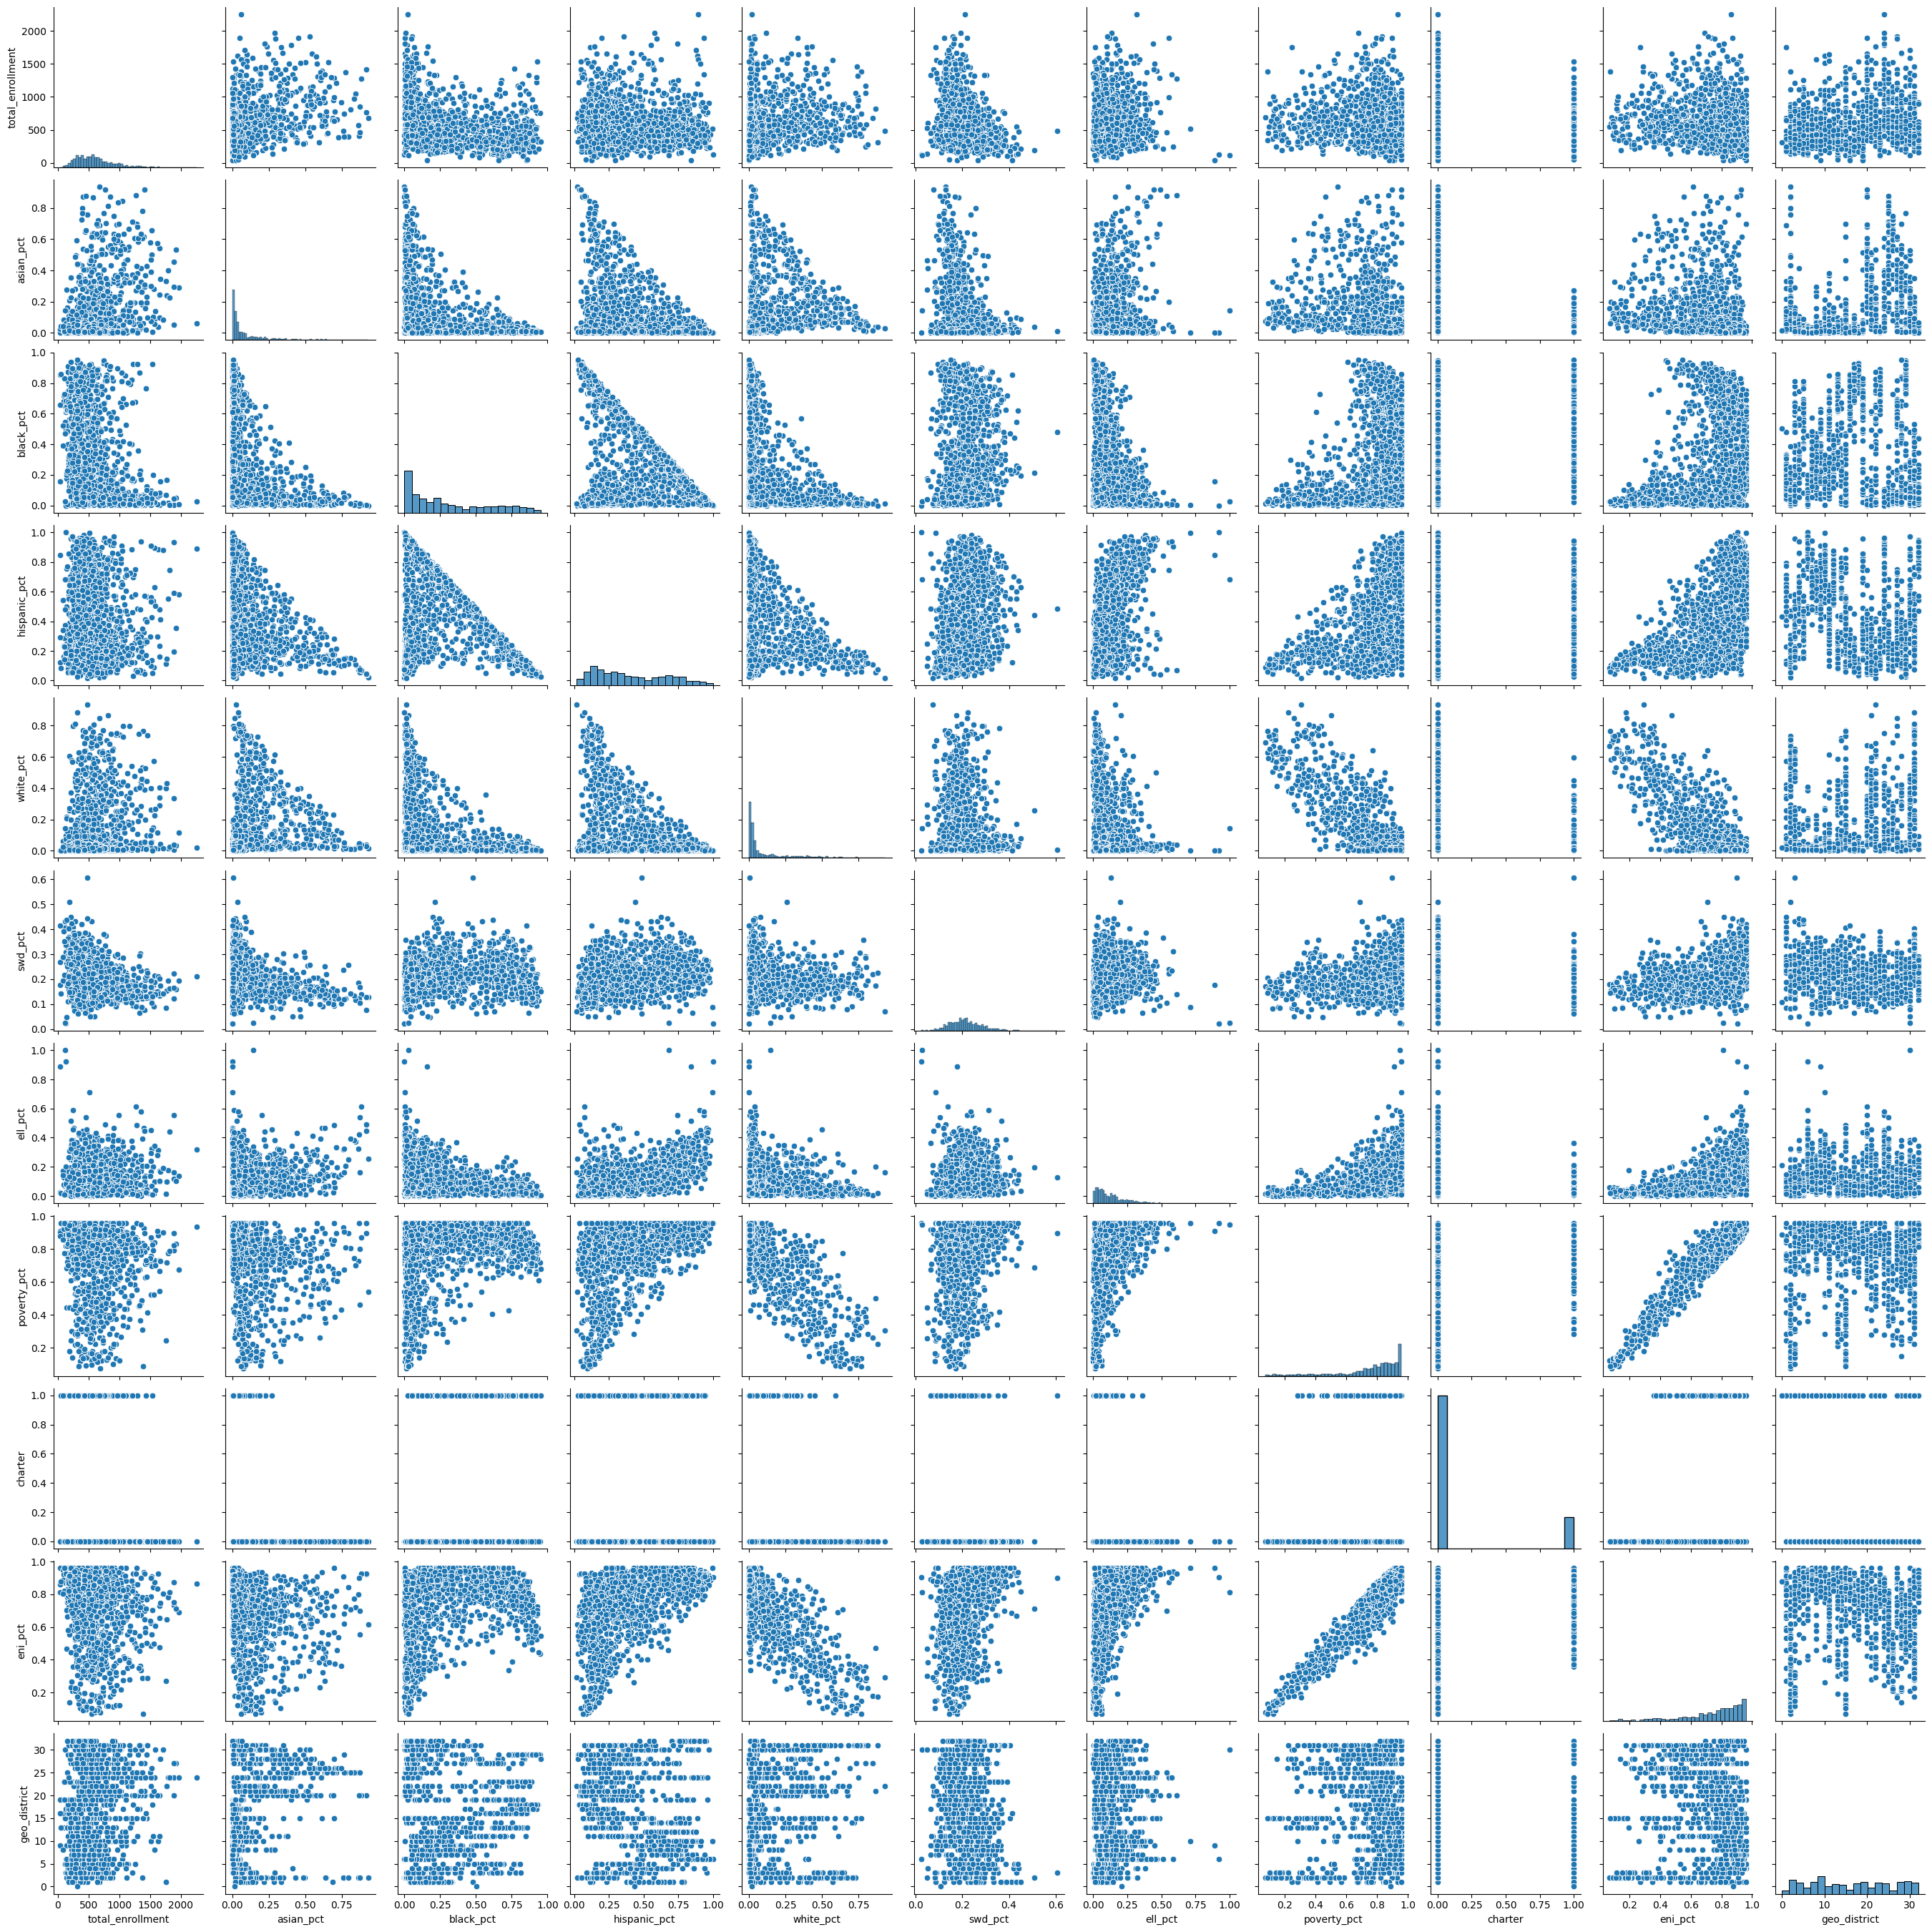

In [4]:
data = data[["mean_scale_score"] + factors]
data.charter = data.charter.apply(lambda x: 1 if x else 0)
corr = data.corr().sort_values(by="mean_scale_score")
corr = corr.style.background_gradient(cmap=plt.cm.coolwarm)
display(md("**Correlation table between factors and mean scale score**"))
display(corr)

display(md("**Scatter plots of correlations showing covariance of factors**"))

sns.pairplot(data[factors])
plt.show()

OLS Linear Regression with different factors
---------------------------------------------

We're going to run a linear regression prediction with several different sets of factors to
see which combination creates the strongest predictive model.

Because the training and testing sets are randomized we will get slightly different results
each time we run the code in this cell. It appears that the factors that total enrollment has
no predictive power and that including poverty_pct without eni_pct produces slightly
better predictions.

In [5]:
model = LinearRegression()

# shuffle our data frame so test, train are randomized, but the same across runs
data = data.sample(frac=1).reset_index(drop=True)

# make a small function so that we can report r2 and mse for different factors

def show_predict(factors, title):
    X = data[factors]
    y = data['mean_scale_score']
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.3)

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    report = f"""
**{title}**

- factors: {factors}
- r2: {r2}
- rmse: {rmse}
"""
    display(md(report))

factors = ['total_enrollment', 'asian_pct','black_pct', 
           'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',
           'poverty_pct', 'charter']
show_predict(factors, "With total enrollment")

factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'charter']
show_predict(factors, "Without total enrollment")

factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',  'poverty_pct', 'eni', 'charter']
show_predict(factors, "Adding ENI" )


factors = ['asian_pct','black_pct', 
       'hispanic_pct',  'white_pct','swd_pct', 'ell_pct', 'eni', 'charter']
show_predict(factors, "ENI without Poverty %" )


**With total enrollment**

- factors: ['total_enrollment', 'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.601374313079333
- rmse: 7.144427248446355



**Without total enrollment**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.6007831036093795
- rmse: 7.149723304653924



**Adding ENI**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'eni_pct', 'charter']
- r2: 0.6018228807403438
- rmse: 7.140406357169124



**ENI without Poverty %**

- factors: ['asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'eni_pct', 'charter']
- r2: 0.6003977404133258
- rmse: 7.153173278418023


Partial Least Squares
===================

In [6]:
factors = ['total_enrollment', 'asian_pct','black_pct', 
           'hispanic_pct',  'white_pct','swd_pct', 'ell_pct',
           'poverty_pct', 'charter']

X = data[factors]
y = data['mean_scale_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.3)

pls = PLSRegression(n_components=len(factors))
pls.fit(X_train, y_train)


predictions = pls.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)
md(f"""
**PLS predict**

- factors: {factors}
- r2: {r2}
- rmse: {rmse}
""")



**PLS predict**

- factors: ['total_enrollment', 'asian_pct', 'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct', 'poverty_pct', 'charter']
- r2: 0.5999520630139812
- rmse: 7.187062154262691


In [7]:
# fit both models with the full data and show the correlations
ols_fit = model.fit(X, y)
pls_fit = pls.fit(X, y)

coef_table = pd.DataFrame(columns=["factor", "pls-coef", "ols-coef"])

coef_table.factor = factors

coef_table["pls-coef"] = [x[0] for x in pls.coef_]
coef_table["ols-coef"] = [x for x in model.coef_]

# coef_table.join(ols_df, on="factor")
coef_table

/home/mxc/.virtualenvs/school-data/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


,factor,pls-coef,ols-coef
0,total_enrollment,0.292540,0.000905
1,asian_pct,3.938312,22.357730
2,black_pct,-0.235673,-0.838275
3,hispanic_pct,1.332454,5.186641
4,white_pct,1.870359,9.845927
5,swd_pct,-2.729158,-39.616177
6,ell_pct,-2.200350,-18.667367
7,poverty_pct,-2.956922,-14.384679
8,charter,3.905203,10.371978


In [8]:
# compare sklearn and statsmodel OLS
y = data['mean_scale_score']

X = data[factors]
X = sm.add_constant(X)
sm_ols = sm.OLS(y, X).fit()

params = list(sm_ols.params.index.values[1:])
coefs = list(sm_ols.params.values[1:],)
pvalues = list(sm_ols.pvalues[1:])
len(params), len(coefs), len(pvalues)
pvalues
ols_df = pd.DataFrame({"factor":params,"sm-coef":coefs,"p-values":pvalues})
# ols_df
coef_table.merge(ols_df,on="factor", how="inner")

,factor,pls-coef,ols-coef,sm-coef,p-values
0,total_enrollment,0.292540,0.000905,0.000905,4.759245e-03
1,asian_pct,3.938312,22.357730,22.357730,4.136083e-08
2,black_pct,-0.235673,-0.838275,-0.838275,8.343130e-01
3,hispanic_pct,1.332454,5.186641,5.186641,1.930317e-01
4,white_pct,1.870359,9.845927,9.845927,1.196722e-02
5,swd_pct,-2.729158,-39.616177,-39.616177,2.500699e-119
6,ell_pct,-2.200350,-18.667367,-18.667367,5.892349e-59
7,poverty_pct,-2.956922,-14.384679,-14.384679,5.709181e-46
8,charter,3.905203,10.371978,10.371978,4.740549e-265


In [9]:
# let's get p-values for the sklearn models
pls_intercept = y_intercept = pls_fit._y_mean - np.dot(pls_fit._x_mean , pls_fit.coef_)
pls_intercept = pls_intercept[0]
pls_intercept
pls_coef = [x[0] for x in pls.coef_]
X = data[factors]
y = data['mean_scale_score']
n = len(data)


beta_hat = [pls_intercept] + pls_coef
beta_hat


from scipy.stats import t
X1 = np.column_stack((np.ones(n), X))
# standard deviation of the noise.
sigma_hat = np.sqrt(np.sum(np.square(y - X1@beta_hat)) / (n - X1.shape[1]))
# estimate the covariance matrix for beta 
beta_cov = np.linalg.inv(X1.T@X1)
# the t-test statistic for each variable from the formula from above figure
t_vals = beta_hat / (sigma_hat * np.sqrt(np.diagonal(beta_cov)))
# compute 2-sided p-values.
p_vals = t.sf(np.abs(t_vals), n-X1.shape[1])*2 
t_vals
# array([ 0.37424023, -2.36373529,  3.57930174])
p_vals



array([2.07183903e-19, 0.00000000e+00, 9.40071536e-01, 9.96353400e-01,
       9.79264969e-01, 9.70396004e-01, 8.98851951e-01, 8.80842705e-01,
       8.18668445e-01, 2.84814328e-01])

### Graph of PLS coefficients

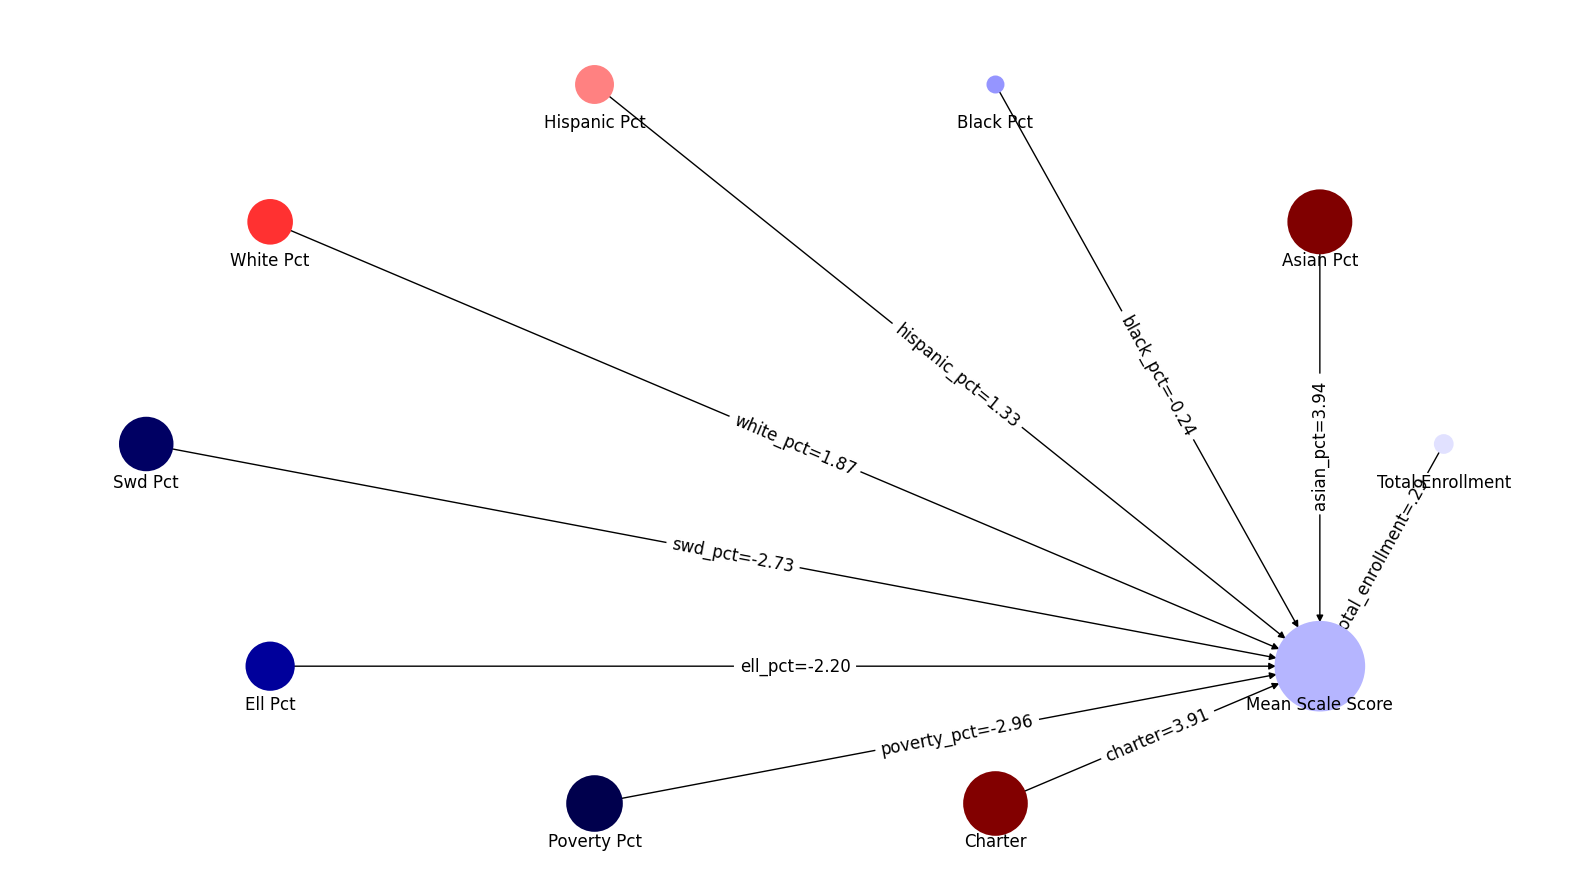

### Graph of OLS coefficients

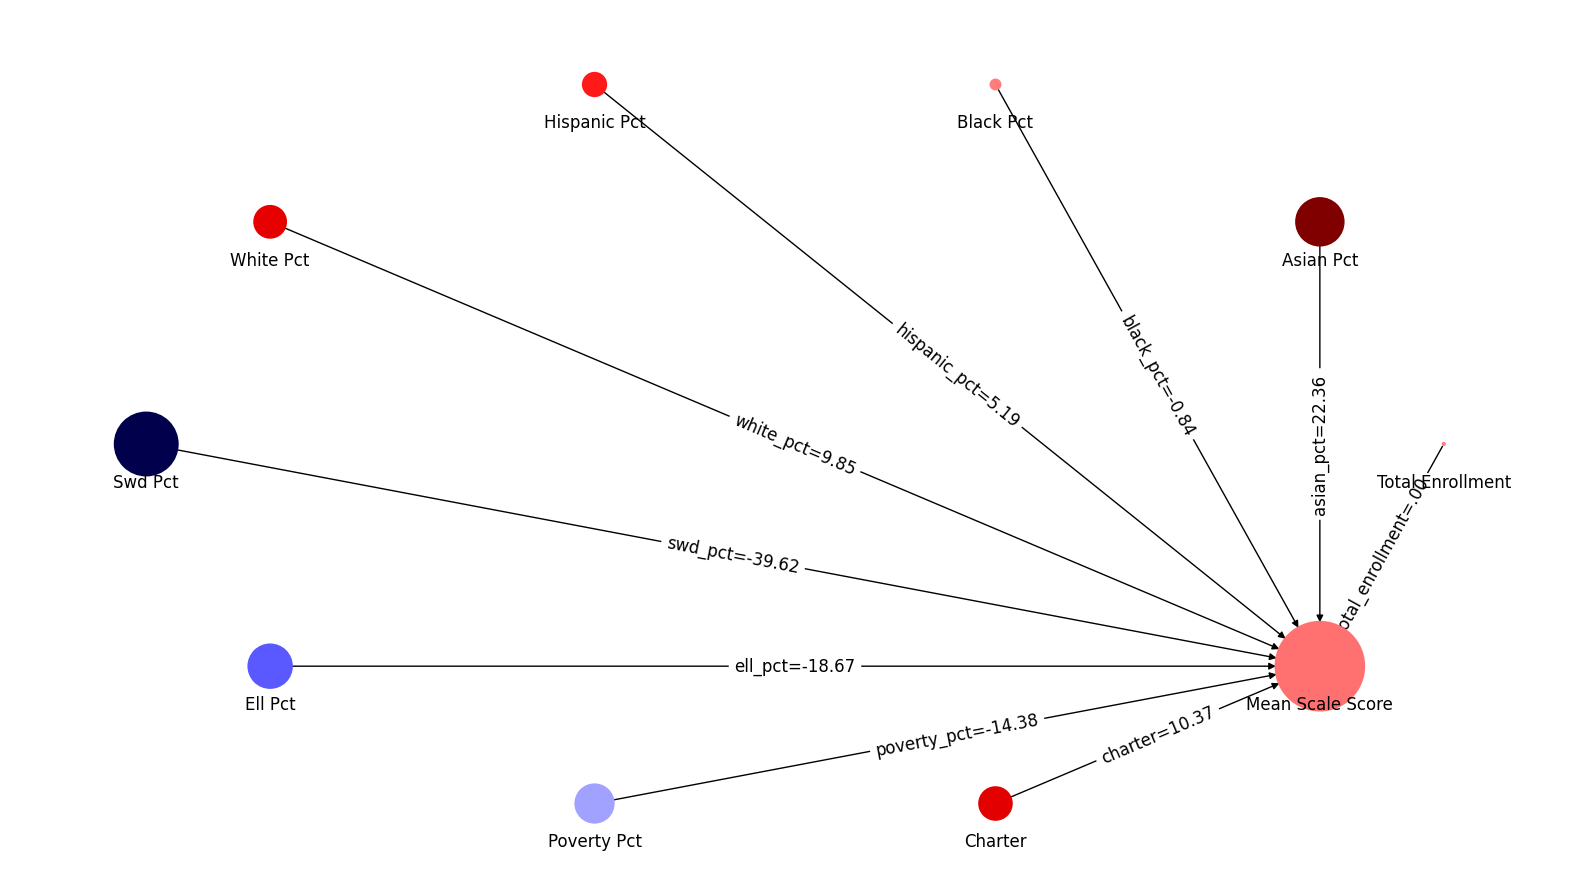

In [10]:
display(md("### Graph of PLS coefficients"))
coefs = [x[0] for x in pls.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)

display(md("### Graph of OLS coefficients"))
coefs = [x for x in model.coef_]
ui.network_map("mean_scale_score", factors, coefs , None)